2025-05-27 17:15:06.250464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748340906.342459    5388 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748340906.371374    5388 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748340906.582173    5388 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748340906.582199    5388 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748340906.582201    5388 computation_placer.cc:177] computation placer alr

Epoch 1/10


2025-05-27 17:15:13.485194: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7888 - loss: 0.7190 - precision: 0.9026 - recall: 0.6682 - val_accuracy: 0.9662 - val_loss: 0.1084 - val_precision: 0.9711 - val_recall: 0.9609
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9670 - loss: 0.1123 - precision: 0.9712 - recall: 0.9622 - val_accuracy: 0.9744 - val_loss: 0.0770 - val_precision: 0.9767 - val_recall: 0.9721
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9762 - loss: 0.0799 - precision: 0.9793 - recall: 0.9741 - val_accuracy: 0.9810 - val_loss: 0.0591 - val_precision: 0.9839 - val_recall: 0.9792
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9817 - loss: 0.0581 - precision: 0.9838 - recall: 0.9801 - val_accuracy: 0.9845 - val_loss: 0.0492 - val_precision: 0.9866 - val_recall: 0.9832
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9850 - loss: 0.0511 - precision: 0.9865 - recall: 0.9834 - val_accuracy: 0.9869 - val_loss: 0.0442 -

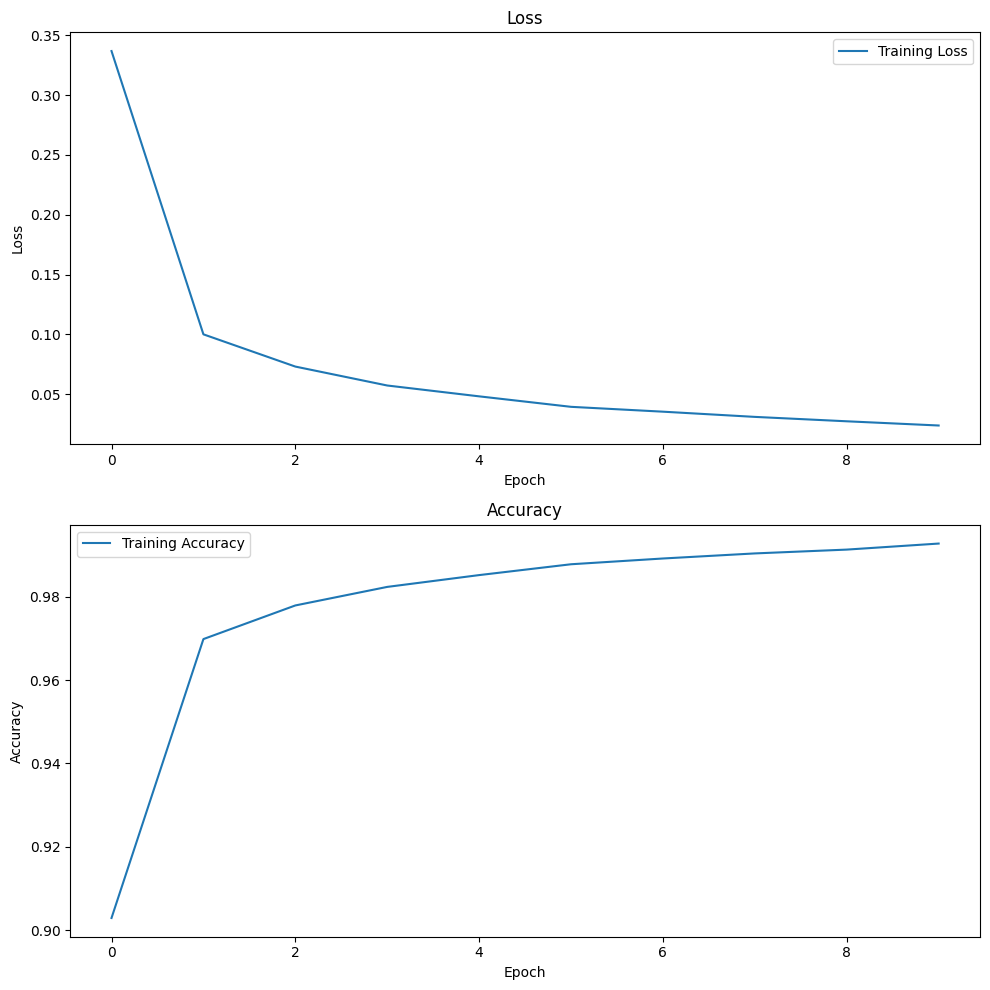

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


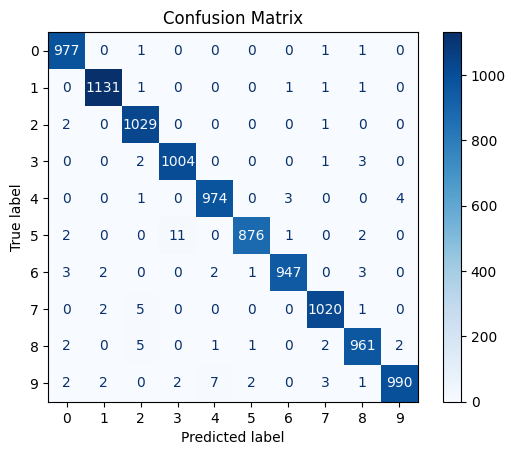

In [1]:
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

def preprocessData():

    (train_X, train_y), (test_X, test_y) = mnist.load_data()

    train_X = train_X[..., np.newaxis] / 255.0
    test_X = test_X[..., np.newaxis] / 255.0

    train_X = tf.pad(train_X, [[0, 0], [2, 2], [2, 2], [0, 0]]).numpy()
    test_X = tf.pad(test_X, [[0, 0], [2, 2], [2, 2], [0, 0]]).numpy()

    train_y = keras.utils.to_categorical(train_y, 10)
    test_y = keras.utils.to_categorical(test_y, 10)

    return train_X, train_y, test_X, test_y


def buildLenetModel(learning_rate=0.001):

    model = keras.Sequential([
        # input 1x32x32, output 6x32x32
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1), padding='same'),
        # input 6x32x32, output 6x16x16
        layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        # input 6x16x16, output 16x12x12
        layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
        # input 16x12x12, output 16x6x6
        layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        # input 16x6x6, output 576 (flatten)
        layers.Flatten(),
        # input 576, output 120
        layers.Dense(units=120, activation='relu'),
        # input 120x1x1, output 84
        layers.Dense(units=84, activation='relu'),
        # input 84, output 10
        layers.Dense(units=10, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    return model


def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Accuracy')
    ax2.legend()

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()


    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


def main():
    train_X, train_y, test_X, test_y = preprocessData()

    model = buildLenetModel(learning_rate=0.001)

    history = model.fit(
        train_X, train_y,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(test_X, test_y)
    )

    plot_training_history(history)

    y_pred = np.argmax(model.predict(test_X), axis=1)
    y_true = np.argmax(test_y, axis=1)
    plot_confusion_matrix(y_true, y_pred)


if __name__ == "__main__":
    main()

## Ручная реализация

In [18]:
import numpy as np


class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1
        self.biases = np.zeros((out_channels, 1))
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        in_channels, H, W = input.shape
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1

        output = np.zeros((self.out_channels, H_out, W_out))

        for oc in range(self.out_channels):
            for i in range(H_out):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                for j in range(W_out):
                    w_start = j * self.stride
                    w_end = w_start + self.kernel_size

                    patch = input[:, h_start:h_end, w_start:w_end]
                    output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
        return output

    def backward(self, d_out, learning_rate):
        input = self.last_input
        _, H, W = input.shape
        H_out, W_out = d_out.shape[1], d_out.shape[2]

        d_input = np.zeros_like(input)
        d_weights = np.zeros_like(self.weights)
        d_biases = np.zeros_like(self.biases)

        for oc in range(self.out_channels):
            d_bias = 0.0
            for i in range(H_out):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                for j in range(W_out):
                    w_start = j * self.stride
                    w_end = w_start + self.kernel_size

                    patch = input[:, h_start:h_end, w_start:w_end]
                    grad = d_out[oc, i, j]

                    d_weights[oc] += grad * patch
                    d_input[:, h_start:h_end, w_start:w_end] += grad * self.weights[oc]
                    d_bias += grad

            d_biases[oc] = d_bias

        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases

        return d_input


class ReLULayer:
    def __init__(self):
        self.last_input = None

    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)

    def backward(self, d_out):
        d_input = d_out.copy()
        d_input[self.last_input <= 0] = 0
        return d_input


class AvgPoolLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.last_input = None  # Cache for backward

    def forward(self, input):

        self.last_input = input
        channels, H, W = input.shape
        H_out = (H - self.pool_size) // self.stride + 1
        W_out = (W - self.pool_size) // self.stride + 1

        output = np.zeros((channels, H_out, W_out))

        for c in range(channels):
            for i in range(H_out):
                h_start = i * self.stride
                h_end = h_start + self.pool_size
                for j in range(W_out):
                    w_start = j * self.stride
                    w_end = w_start + self.pool_size

                    window = input[c, h_start:h_end, w_start:w_end]
                    output[c, i, j] = np.mean(window)

        return output

    def backward(self, d_out):

        input = self.last_input
        channels, H, W = input.shape
        H_out, W_out = d_out.shape[1], d_out.shape[2]
        d_input = np.zeros_like(input)

        pool_area = self.pool_size * self.pool_size

        for c in range(channels):
            for i in range(H_out):
                h_start = i * self.stride
                h_end = h_start + self.pool_size
                for j in range(W_out):
                    w_start = j * self.stride
                    w_end = w_start + self.pool_size

                    grad = d_out[c, i, j] / pool_area
                    d_input[c, h_start:h_end, w_start:w_end] += grad

        return d_input


class FCLayer:
    def __init__(self, input_size, output_size):

        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size) * 0.1
        self.biases = np.zeros((output_size, 1))
        self.last_input = None

    def forward(self, input):

        self.last_input = input
        return np.dot(self.weights, input) + self.biases

    def backward(self, d_out, learning_rate):

        d_weights = np.dot(d_out, self.last_input.T)
        d_biases = np.sum(d_out, axis=1, keepdims=True)

        d_input = np.dot(self.weights.T, d_out)

        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases

        return d_input


def softmax(x):
    exp_shifted = np.exp(x - np.max(x))
    return exp_shifted / np.sum(exp_shifted, axis=0)


def cross_entropy_loss(probs, target_index):
    return -np.log(probs[target_index, 0] + 1e-9)


def softmax_cross_entropy_backward(probs, target_index):
    grad = probs.copy()
    grad[target_index] -= 1
    return grad


class Lenet5:
    def __init__(self):
        self.flat_shape = None
        self.conv1 = ConvLayer(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.relu1 = ReLULayer()
        self.pool1 = AvgPoolLayer(pool_size=2, stride=2)
        self.conv2 = ConvLayer(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.relu2 = ReLULayer()
        self.pool2 = AvgPoolLayer(pool_size=2, stride=2)
        self.fc1 = FCLayer(input_size=16 * 5 * 5, output_size=120)
        self.relu3 = ReLULayer()
        self.fc2 = FCLayer(input_size=120, output_size=84)
        self.relu4 = ReLULayer()
        self.fc3 = FCLayer(input_size=84, output_size=10)

    def forward(self, x):
        out = self.conv1.forward(x)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)
        self.flat_shape = out.shape
        out_flat = out.reshape(-1, 1)
        out = self.fc1.forward(out_flat)
        out = self.relu3.forward(out)
        out = self.fc2.forward(out)
        out = self.relu4.forward(out)
        out = self.fc3.forward(out)
        probs = softmax(out)
        return probs

    def backward(self, d_loss, learning_rate):
        d_out = self.fc3.backward(d_loss, learning_rate)
        d_out = self.relu4.backward(d_out)
        d_out = self.fc2.backward(d_out, learning_rate)
        d_out = self.relu3.backward(d_out)
        d_out = self.fc1.backward(d_out, learning_rate)
        d_out = d_out.reshape(self.flat_shape)
        d_out = self.pool2.backward(d_out)
        d_out = self.relu2.backward(d_out)
        d_out = self.conv2.backward(d_out, learning_rate)
        d_out = self.pool1.backward(d_out)
        d_out = self.relu1.backward(d_out)
        d_out = self.conv1.backward(d_out, learning_rate)
        return d_out


Epoch 1/10:


Training:   0%|          | 0/800 [00:00<?, ?it/s]/tmp/ipykernel_450464/2959027506.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[oc, i, j] = np.sum(patch * self.weights[oc]) + self.biases[oc]
Training: 100%|██████████| 800/800 [01:13<00:00, 10.84it/s]


Epoch 1 metrics:
  Loss: 0.8128
  Accuracy: 69.50%
----------------------------------------

Epoch 2/10:


Training: 100%|██████████| 800/800 [01:15<00:00, 10.61it/s]


Epoch 2 metrics:
  Loss: 0.5568
  Accuracy: 81.00%
----------------------------------------

Epoch 3/10:


Training: 100%|██████████| 800/800 [01:13<00:00, 10.91it/s]


Epoch 3 metrics:
  Loss: 0.3022
  Accuracy: 89.50%
----------------------------------------

Epoch 4/10:


Training: 100%|██████████| 800/800 [01:15<00:00, 10.65it/s]


Epoch 4 metrics:
  Loss: 0.2098
  Accuracy: 93.00%
----------------------------------------

Epoch 5/10:


Training: 100%|██████████| 800/800 [01:12<00:00, 10.98it/s]


Epoch 5 metrics:
  Loss: 0.2336
  Accuracy: 91.00%
----------------------------------------

Epoch 6/10:


Training: 100%|██████████| 800/800 [01:13<00:00, 10.89it/s]


Epoch 6 metrics:
  Loss: 0.1839
  Accuracy: 94.50%
----------------------------------------

Epoch 7/10:


Training: 100%|██████████| 800/800 [01:13<00:00, 10.92it/s]


Epoch 7 metrics:
  Loss: 0.4505
  Accuracy: 86.50%
----------------------------------------

Epoch 8/10:


Training: 100%|██████████| 800/800 [01:13<00:00, 10.85it/s]


Epoch 8 metrics:
  Loss: 0.1593
  Accuracy: 95.50%
----------------------------------------

Epoch 9/10:


Training: 100%|██████████| 800/800 [01:12<00:00, 10.99it/s]


Epoch 9 metrics:
  Loss: 0.1842
  Accuracy: 96.50%
----------------------------------------

Epoch 10/10:


Training: 100%|██████████| 800/800 [01:13<00:00, 10.90it/s]


Epoch 10 metrics:
  Loss: 0.2940
  Accuracy: 92.50%
----------------------------------------


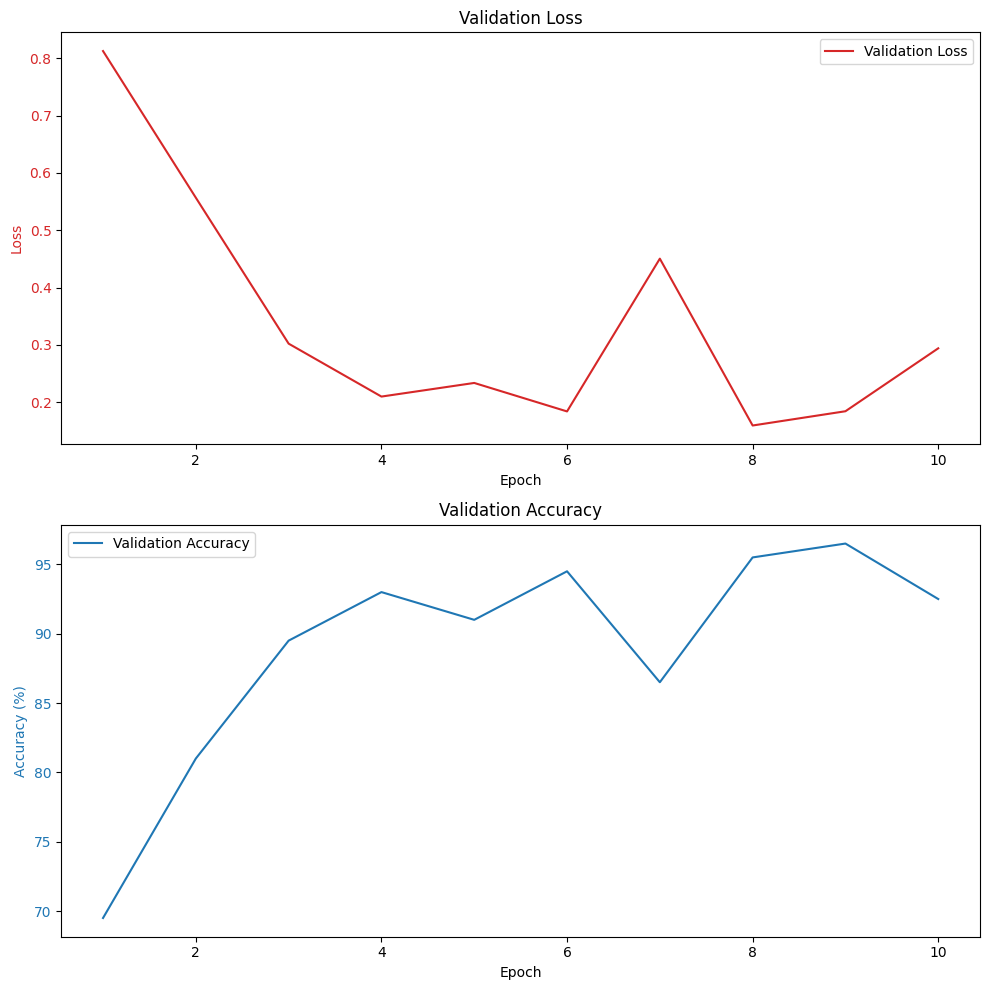

100%|██████████| 200/200 [00:08<00:00, 22.72it/s]


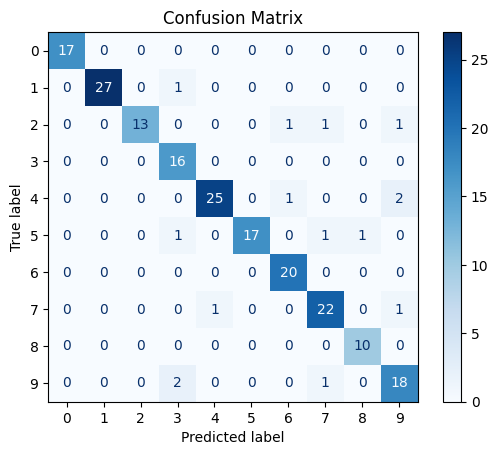

In [19]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm


def evaluate_model(model, test_images, test_labels) -> tuple[float, float]:

    total_loss = 0.0
    correct_predictions = 0

    for image, true_label in zip(test_images, test_labels):
        probabilities = model.forward(image)

        loss = cross_entropy_loss(probabilities, true_label)
        total_loss += loss

        predicted_class = np.argmax(probabilities.ravel())
        if predicted_class == true_label:
            correct_predictions += 1

    average_loss = total_loss / len(test_images)
    accuracy_percentage = (correct_predictions / len(test_images)) * 100

    return average_loss, accuracy_percentage


def preprocess_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    train_images = train_images.astype(np.float32) / 255.0
    test_images = test_images.astype(np.float32) / 255.0

    train_images = np.expand_dims(train_images, axis=1)
    test_images = np.expand_dims(test_images, axis=1)

    padding = ((0, 0), (0, 0), (2, 2), (2, 2))
    train_images = np.pad(train_images, padding, mode='constant')
    test_images = np.pad(test_images, padding, mode='constant')

    train_images = train_images[:800]
    train_labels = train_labels[:800]
    test_images = test_images[:200]
    test_labels = test_labels[:200]

    return train_images, train_labels, test_images, test_labels


def train_model(model, train_images, train_labels, test_images, test_labels, num_epochs=10, learning_rate=0.01):

    loss_history = []
    accuracy_history = []

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}:")
        for image, true_label in tqdm(zip(train_images, train_labels),
                                      total=len(train_images),
                                      desc="Training"):
            probabilities = model.forward(image)

            cross_entropy_loss(probabilities, true_label)
            gradient = softmax_cross_entropy_backward(probabilities, true_label)
            model.backward(gradient, learning_rate)

        epoch_loss, epoch_accuracy = evaluate_model(model, test_images, test_labels)
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch} metrics:")
        print(f"  Loss: {epoch_loss:.4f}")
        print(f"  Accuracy: {epoch_accuracy:.2f}%")
        print("-" * 40)

    return loss_history, accuracy_history


def plot_metrics(loss_history, accuracy_history):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(1, len(loss_history) + 1), loss_history, color='tab:red', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper right')
    ax1.set_title("Validation Loss")

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(range(1, len(accuracy_history) + 1), accuracy_history,
             color='tab:blue', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.legend(loc='upper left')
    ax2.set_title("Validation Accuracy")

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, test_images, test_labels):
    true_classes = []
    predicted_classes = []

    for image, true_label in tqdm(zip(test_images, test_labels), total=len(test_images)):
        probabilities = model.forward(image)
        predicted_class = np.argmax(probabilities)
        predicted_classes.append(predicted_class)
        true_classes.append(true_label)

    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


def main():
    train_images, train_labels, test_images, test_labels = preprocess_data()

    model = Lenet5()

    loss_history, accuracy_history = train_model(
        model,
        train_images,
        train_labels,
        test_images,
        test_labels,
        num_epochs=10,
        learning_rate=0.01
    )

    plot_metrics(loss_history, accuracy_history)
    plot_confusion_matrix(model, test_images, test_labels)


if __name__ == "__main__":
    main()